# Train cat classifier v0

In [33]:
import sys
import os
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [2]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #pyplot.savefig(filename + '_plot.png')
    #pyplot.close()

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

In [37]:
path_data_train = '../data/train/'
path_data_val = '../data/val/'
path_data_test = '../data/test/'

path_models = '../models/final/'

## Create dataset iterators

In [134]:
# create data generator
datagen = ImageDataGenerator(featurewise_center=True)

# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]

# prepare iterator
train_it = datagen.flow_from_directory(path_data_train, class_mode='binary', batch_size=64, target_size=(224, 224))
val_it = datagen.flow_from_directory(path_data_val, class_mode='binary', batch_size=64, target_size=(224, 224))
#test_it = datagen.flow_from_directory(path_data_test, class_mode='binary', batch_size=64, target_size=(224, 224))

Found 232 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [135]:
print(train_it.image_shape)
print(train_it.class_indices)
print(train_it.color_mode)
print('Num Class train no_cat: ' + str(sum(train_it.classes==1)))
print('Num Class train cat: ' + str(sum(train_it.classes==0)))
print('Num Class val no_cat: ' + str(sum(val_it.classes==1)))
print('Num Class val cat: ' + str(sum(val_it.classes==0)))

(224, 224, 3)
{'cat': 0, 'no_cat': 1}
rgb
Num Class train no_cat: 207
Num Class train cat: 25
Num Class val no_cat: 62
Num Class val cat: 10


## Build model

In [172]:
# load model
model = VGG16(include_top=False, input_shape=(224, 224, 3))

# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(1, activation='sigmoid')(class1)

# define new model
model = Model(inputs=model.inputs, outputs=output)

In [173]:
#model.summary()

In [174]:
# compile model
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

## Train and evaluate model

In [175]:
# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=val_it, validation_steps=len(val_it), epochs=2, verbose=1)

Epoch 1/2
4/4 [==============================] - 37s 10s/step - loss: 0.6850 - accuracy: 0.8320 - val_loss: 6.2293 - val_accuracy: 0.4028
Epoch 2/2
4/4 [==============================] - 39s 10s/step - loss: 10.9111 - accuracy: 0.6613 - val_loss: 9.1241 - val_accuracy: 0.9028


In [117]:
# Calculate metrics model
eval_res = model.evaluate(val_it, steps=len(val_it), verbose=1)

1/1 [==============================] - 6s 6s/step - loss: 0.4915 - accuracy: 0.9833


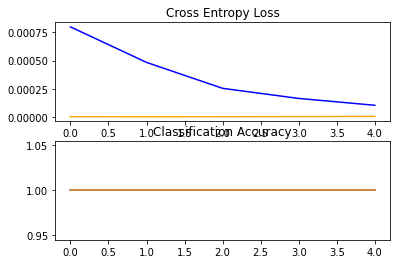

In [162]:
# learning curves
summarize_diagnostics(history)

## Save model

In [141]:
model.save(path_models + 'cat_classifier_v0_tobivscatflap/',save_format='tf')

INFO:tensorflow:Assets written to: ../models/final/cat_classifier_v0_tobivscatflap/assets


## Load model

In [169]:
# load model
model = load_model(path_models + 'cat_classifier_v0_tobivscatflap/')

In [158]:
# Set trainable layer
for layer in model.layers:
    layer.trainable = True
    if layer.name not in ['dense_11']:
        layer.trainable = False

In [159]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## Predict on test data

In [176]:
# Predict on test data
print(train_it.class_indices)
print('Cats')
test_imgs_cat = os.listdir(path_data_test + 'cat')
test_imgs_cat.sort()
for test_img in test_imgs_cat:
    if test_img.endswith('.jpg'):
        full_path = path_data_test + 'cat/' + test_img
        img = load_image(full_path)
        result = model.predict(img)
        print(test_img + ': ' + str(round(result[0][0],3)))
        
print('=======')
print('No Cats')
test_imgs_nocat = os.listdir(path_data_test + 'no_cat')
test_imgs_nocat.sort()
for test_img in test_imgs_nocat:
    if test_img.endswith('.jpg'):
        full_path = path_data_test + 'no_cat/' + test_img
        img = load_image(full_path)
        result = model.predict(img)
        print(test_img + ': ' + str(round(result[0][0],3)))


{'cat': 0, 'no_cat': 1}
Cats
12_942623.jpg: 1.0
20_325695.jpg: 1.0
20_901157.jpg: 1.0
21_476670.jpg: 0.145
22_772459.jpg: 1.0
30_273484.jpg: 1.0
31_195851.jpg: 1.0
No Cats
16_646319.jpg: 1.0
16_834072.jpg: 1.0
16_978774.jpg: 1.0
17_046927.jpg: 1.0
17_284032.jpg: 1.0
17_554072.jpg: 1.0
17_586181.jpg: 1.0
img_20210106_000819.377645.jpg: 1.0
img_20210106_001933.811890.jpg: 1.0
img_20210106_003734.316094.jpg: 1.0
img_20210106_004640.384644.jpg: 1.0
img_20210106_005031.012111.jpg: 1.0
img_20210106_005137.891308.jpg: 1.0
img_20210106_013905.537194.jpg: 1.0
img_20210106_044508.210066.jpg: 1.0
img_20210106_125622.435941.jpg: 1.0
img_20210106_125625.939644.jpg: 1.0
img_20210106_125654.476259.jpg: 1.0
img_20210106_125703.478593.jpg: 1.0
img_20210106_131053.547518.jpg: 1.0
img_20210106_131124.379874.jpg: 1.0
img_20210106_131152.177523.jpg: 1.0
img_20210106_131210.179764.jpg: 1.0
img_20210106_131228.654551.jpg: 1.0
img_20210106_144625.291874.jpg: 1.0
img_20210106_150302.663325.jpg: 1.0
img_2021010

In [29]:
# load the image
#test_img_cat = load_image('../data/val/cat/cat.2501.jpg')
test_img_cat = load_image('../data/test/cat/58_422561.jpg')
test_img_dog = load_image('../data/val/no_cat/dog.2504.jpg')

#img = load_image('../data/test/cat/img_20210106_022522.772459.jpg')#58_422561.jpg
#img = load_image('../data/test/no_cat/06_007499.jpg')#06_007499.jpg

In [54]:
# predict the class
result = model.predict(test_img_cat)
print(str(round(result[0][0],3)))

0.0


In [55]:
result = model.predict(test_img_dog)
print(str(round(result[0][0],3)))

1.0
